In [12]:
# coding: utf-8

import numpy as np

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from collections import deque, Counter

import random
import json
import os
import io
import sys
import time

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))

    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)

    def __len__(self):
        return len(self.buffer)

class Env(object):
    def __init__(self, num_bits):
        self.num_bits = num_bits

    def reset(self):
        self.done      = False
        self.num_steps = 0
        self.state     = np.random.randint(2, size=self.num_bits)
        self.target    = np.random.randint(2, size=self.num_bits)
        return self.state, self.target

    def step(self, action):
        if self.done:
            raise RESET

        self.state[action] = 1 - self.state[action]

        if self.num_steps > self.num_bits + 1:
            self.done = True
        self.num_steps += 1

        if np.sum(self.state == self.target) == self.num_bits:
            self.done = True
            return np.copy(self.state), 0, self.done, {}
        else:
            return np.copy(self.state), -1, self.done, {}

def make_model(num_actions, input_size, hidden_size):
    state = Input(shape=(input_size,))
    goal = Input(shape=(input_size,))
    l1 = Concatenate(axis=-1)([state, goal])
    l2 = Dense(hidden_size, activation='relu')(l1)
    out = Dense(num_actions)(l2)
    model = Model(input=[state, goal], output=out)
    optimizer = Adam()
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

def update_weights(source, target):
    target.set_weights(source.get_weights()) 

def get_action(model, state, goal, epsilon=0.1):
    if random.random() < epsilon:
        return random.randrange(env.num_bits)
    state = np.expand_dims((state), axis=0)
    goal = np.expand_dims((goal), axis=0)
    q_value = model.predict([state, goal])
    return np.argmax(q_value)

In [2]:
num_bits = 11
env = Env(num_bits)

model = make_model(num_bits, num_bits, 256)
target_model = make_model(num_bits, num_bits, 256)
update_weights(model, target_model)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 22)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          5888        concatenate_1[0][0]              
__________

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards, losses, losses2):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Mean Reward: %s. frame: %s' % (rewards[-1], frame_idx))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('loss2')
    plt.plot(losses2)
    plt.show()

In [4]:
def gather(a, b):
    return np.array([a[index][b[index]] for index in range(len(a))])

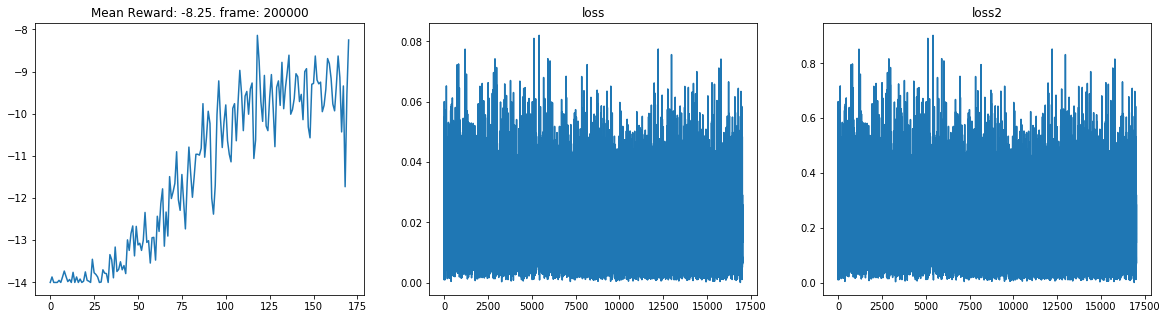

Counter({-1: 64269, 0: 20811})


In [13]:
batch_size = 5
new_goals = 5
max_frames = 200000

random.seed(1)

replay_buffer = ReplayBuffer(10000)

episodes = 0
iterations = 0
all_rewards = []
losses = []
losses2 = []
reward_counts = Counter()
print("Starting training")

while iterations < max_frames:
    episodes += 1
    state, goal = env.reset()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, reward, done, next_state, goal))
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        iterations += 1
        
        if iterations % 5000 == 0:
            plot(iterations, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses, losses2)
            print(reward_counts)

    all_rewards.append(total_reward)
    
    new_episode = []
    for state, reward, done, next_state, goal in episode:
        for t in np.random.choice(num_bits, new_goals):
            try:
                episode[t]
            except:
                continue
            new_goal = episode[t][3]
            if np.sum(next_state == new_goal) == num_bits:
                reward = 0
            else:
                reward = -1
            replay_buffer.push(state, action, reward, next_state, done, new_goal)
            new_episode.append((state, reward, done, next_state, new_goal))
    #sys.exit(0)
    if len(replay_buffer)> batch_size:
        states, actions, rewards, next_states, dones, goals = replay_buffer.sample(batch_size)
        for r in rewards:
            reward_counts[r] += 1
        mask = np.array([[1 - int(x)] for x in dones])
        actions = np.array([[x] for x in actions])
        rewards = np.array([[x] for x in rewards])

        q_values = model.predict([states, goals])
        q_value = gather(q_values, actions)

        next_q_values = target_model.predict([next_states, goals])
        target_actions = np.array([[np.argmax(x)] for x in next_q_values])
        next_q_value = gather(next_q_values, target_actions)

        expected_q_values = rewards + (0.99 * next_q_value * mask)

        for n in range(0, batch_size):
            q_values[n][actions[n]] = expected_q_values[n]

        loss2 = np.mean(np.square((q_value - expected_q_values)))
        loss, accuracy = model.train_on_batch([states, goals], q_values)
        if loss is not None:
            losses.append(loss)
            losses2.append(loss2)